# **Intro**

This script will compare DIVA and BayesPrism results specifically focusing on SM2 prediction.

"As BayesPrism assumes that the stromal cells share the same expression profiles across patients, allowing it to pool the statistical strength across bulk RNA-seq samples." !!! 
Since our SM2 test set imposes structural coherency across the samples Baywsprism can take advantage of this.

# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [12]:
import os, sys
RUN_COLAB = False

if RUN_COLAB:
    NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
    sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')


In [13]:
# prelude: set up git, etc.
if RUN_COLAB:
    %cd {NB_ROOT_PATH}
    !( source setup.sh )


In [17]:
if RUN_COLAB:
    print("hi")
    # do your git operations here
    %%bash
    #git status


# **Imports**

In [18]:
# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.stats import spearmanr, pearsonr


# Images, plots, display, and visualization
import plotnine as gg
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import gzip
from pathlib import Path

pd.set_option("display.max_columns", None)



# Load Results

In [20]:
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_pbmc_data/"
diva_res_data_path = f"{os.getcwd()}/../results/single_cell_data/diva_pbmc/"
bp_res_data_path = f"{os.getcwd()}/../results/single_cell_data/bp_pbmc/"


def read_files(data_path, file_idx, file_name):
  pbmc_rep1_pseudobulk_file = os.path.join(data_path, f"{file_name}_pseudo_{file_idx}.pkl")
  pbmc_rep1_prop_file = os.path.join(data_path, f"{file_name}_prop_{file_idx}.pkl")
  pbmc_rep1_gene_file = os.path.join(data_path, f"{file_name}_genes.pkl")

  pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
  prop_path = Path(pbmc_rep1_prop_file)
  gene_path = Path(pbmc_rep1_gene_file)

  prop_df = pickle.load( open( prop_path, "rb" ) )
  pseudobulks_df = pickle.load( open( pseudobulk_path, "rb" ) )
  gene_df = pickle.load( open( gene_path, "rb" ) )

  return (pseudobulks_df, prop_df, gene_df)

def read_results(data_path, train_name, test_name, method_str, ext):
  res_file = os.path.join(data_path, f"train-{train_name}-test-{test_name}-{method_str}.{ext}")
  res_path = Path(res_file)

  if ext == "pkl":
    res_df = pickle.load( open( res_path, "rb" ) )
  elif ext == "csv":
    res_df = pd.read_csv(res_file)
  else:
    res_df = pd.read_csv(res_file, sep="\t")

  return res_df


# load the TRUE labels
X_newtech, Y_newtech, newtech_gene_df = read_files(aug_data_path, 0, "pbmc_rep1_sm2")

Y_sm2 = Y_newtech.copy(deep=True)

# we also need to ensure that the cell-types that are unobserved are still there
Y_newtech['Natural killer cell'] = 0
Y_newtech['Dendritic cell'] = 0
Y_newtech['Plasmacytoid dendritic cell'] = 0



# load the DIVA results
diva_newtech = read_results(diva_res_data_path, "pbmc_rep2_10xV2", "pbmc_rep1_sm2", "DIVA", "pkl")

diva_newtech = diva_newtech[Y_newtech.columns]
diva_newtech = diva_newtech.to_numpy()

diva_sm2 = read_results(diva_res_data_path, "pbmc_rep1_sm2", "pbmc_rep1_sm2", "DIVA", "pkl")
diva_sm2 = diva_sm2[Y_sm2.columns]
diva_sm2 = diva_sm2.to_numpy()


diva_10x_sm2 = read_results(diva_res_data_path, "pbmc_rep1_10xV2a_sm2_cells", "pbmc_rep1_sm2", "DIVA", "pkl")
diva_10x_sm2 = diva_10x_sm2[Y_sm2.columns]
diva_10x_sm2 = diva_10x_sm2.to_numpy()


# load the bayesprism results
bp_str = "bp_1000_prop"
bp_newtech = read_results(bp_res_data_path, "pbmc_rep2_10xV2", "pbmc_rep1_sm2", bp_str, "tsv")

bp_newtech = bp_newtech[Y_newtech.columns]
bp_newtech = bp_newtech.to_numpy()

bp_sm2 = read_results(bp_res_data_path, "pbmc_rep1_sm2", "pbmc_rep1_sm2", bp_str, "tsv")
bp_sm2 = bp_sm2[Y_sm2.columns]
bp_sm2 = bp_sm2.to_numpy()


bp_10x_sm2 = read_results(bp_res_data_path, "pbmc_rep1_10xV2a_sm2_cells", "pbmc_rep1_sm2", bp_str, "tsv")
bp_10x_sm2 = bp_10x_sm2[Y_sm2.columns]
bp_10x_sm2 = bp_10x_sm2.to_numpy()



Y_newtech = Y_newtech.to_numpy()
Y_sm2 = Y_sm2.to_numpy()


FileNotFoundError: [Errno 2] No such file or directory: '/beevol/home/davidson/checkouts/sc_bulk_ood/method_comparison/../results/single_cell_data/bp_pbmc/train-pbmc_rep1_sm2-test-pbmc_rep1_sm2-bp_1000_prop.tsv'

In [6]:
Y_newtech[:,0:6] 

array([[0.36, 0.05, 0.07, 0.045, 0.345, 0.13],
       [0.03, 0.51, 0.08, 0.02, 0.22, 0.14],
       [0.135, 0.1, 0.265, 0.185, 0.19, 0.125],
       ...,
       [0.35, 0.19, 0.275, 0.085, 0.02, 0.08],
       [0.015, 0.1, 0.04, 0.43, 0.03, 0.385],
       [0.185, 0.085, 0.32, 0.02, 0.325, 0.065]], dtype=object)

# Compare Methods

In [7]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df



In [8]:
# overall error
diva_newtech_err = get_errors(Y_newtech, diva_newtech)
diva_newtech_err["experiment"] = ["newtech"]*Y_newtech.shape[0]*3
diva_newtech_err["method"] = ["diva"]*Y_newtech.shape[0]*3

bp_newtech_err = get_errors(Y_newtech, bp_newtech)
bp_newtech_err["experiment"] = ["newtech"]*bp_newtech.shape[0]*3
bp_newtech_err["method"] = ["bp"]*bp_newtech.shape[0]*3

diva_newtech_nomissing_err = get_errors(Y_newtech[:,0:6], diva_newtech[:,0:6])
diva_newtech_nomissing_err["experiment"] = ["newtech"]*Y_newtech.shape[0]*3
diva_newtech_nomissing_err["method"] = ["diva_shared_cells"]*Y_newtech.shape[0]*3

bp_newtech_nomissing_err = get_errors(Y_newtech[:,0:6], bp_newtech[:,0:6])
bp_newtech_nomissing_err["experiment"] = ["newtech"]*bp_newtech.shape[0]*3
bp_newtech_nomissing_err["method"] = ["bp_shared_cells"]*bp_newtech.shape[0]*3

diva_sm2_err = get_errors(Y_sm2, diva_sm2)
diva_sm2_err["experiment"] = ["sm2"]*Y_sm2.shape[0]*3
diva_sm2_err["method"] = ["diva"]*Y_sm2.shape[0]*3

bp_sm2_err = get_errors(Y_sm2, bp_sm2)
bp_sm2_err["experiment"] = ["sm2"]*bp_sm2.shape[0]*3
bp_sm2_err["method"] = ["bp"]*bp_sm2.shape[0]*3


diva_sm2_err = get_errors(Y_sm2, diva_sm2)
diva_sm2_err["experiment"] = ["sm2"]*Y_sm2.shape[0]*3
diva_sm2_err["method"] = ["diva"]*Y_sm2.shape[0]*3

bp_sm2_err = get_errors(Y_sm2, bp_sm2)
bp_sm2_err["experiment"] = ["sm2"]*bp_sm2.shape[0]*3
bp_sm2_err["method"] = ["bp"]*bp_sm2.shape[0]*3


diva_10x_sm2_err = get_errors(Y_sm2, diva_10x_sm2)
diva_10x_sm2_err["experiment"] = ["10x_sm2"]*Y_sm2.shape[0]*3
diva_10x_sm2_err["method"] = ["diva"]*Y_sm2.shape[0]*3

bp_10x_sm2_err = get_errors(Y_sm2, bp_10x_sm2)
bp_10x_sm2_err["experiment"] = ["10x_sm2"]*bp_10x_sm2.shape[0]*3
bp_10x_sm2_err["method"] = ["bp"]*bp_10x_sm2.shape[0]*3


MSqE mean: 0.032537345616973454, median: 0.02802199613751731, max: 0.1299114476665254
Spearman mean: 0.16163568513137017, median: 0.16562730837468242, max: 0.910844487911861
Pearson mean: 0.14300043946640273, median: 0.08834363068121077, max: 0.9741538755117715
MSqE mean: 0.030876229145541213, median: 0.02782660256044365, max: 0.07387164586353626
Spearman mean: 0.3180150934301934, median: 0.32208016421988495, max: 0.5594023904871686
Pearson mean: 0.3027394700158575, median: 0.22443898104174373, max: 0.9137761425605643
MSqE mean: 0.04213216593065472, median: 0.033484632899303236, max: 0.19473207742431833
Spearman mean: 0.004759218393331055, median: 0.028571428571428574, max: 1.0
Pearson mean: 0.02002706397966184, median: -0.0390653432230499, max: 0.9930379777859853
MSqE mean: 0.044166722606530574, median: 0.04021714099783877, max: 0.10861855031922278
Spearman mean: 0.30936396267269695, median: 0.3714285714285715, max: 0.550782483869826
Pearson mean: 0.1841051043763882, median: 0.0240112

# Plot Comparisons

       error error_type experiment method
0   0.039967        MSQ    newtech   diva
1   0.025288        MSQ    newtech   diva
2   0.007215        MSQ    newtech   diva
3   0.012511        MSQ    newtech   diva
4   0.013531        MSQ    newtech   diva
..       ...        ...        ...    ...
25  0.071625       PEAR    10x_sm2     bp
26  0.015250       PEAR    10x_sm2     bp
27  0.134874       PEAR    10x_sm2     bp
28  0.000227       PEAR    10x_sm2     bp
29 -0.251853       PEAR    10x_sm2     bp

[12120 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


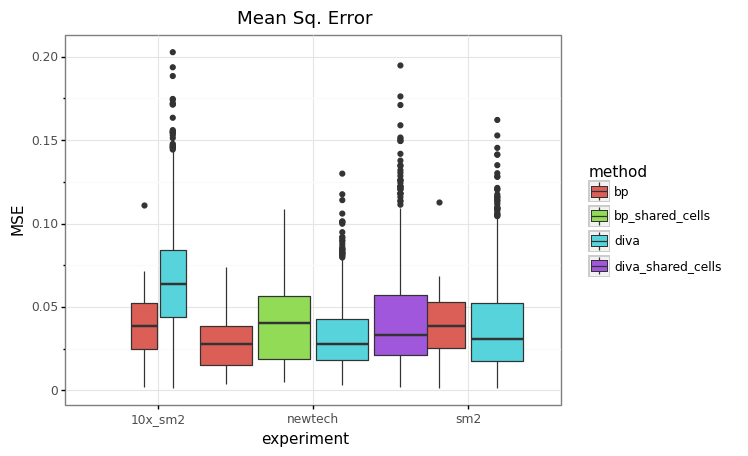

<ggplot: (8790251792041)>

In [9]:
plot_df = pd.concat([diva_newtech_err, diva_newtech_nomissing_err,
                     bp_newtech_err, bp_newtech_nomissing_err,
                     diva_sm2_err, bp_sm2_err,
                     diva_10x_sm2_err, bp_10x_sm2_err])
print(plot_df)
(
    gg.ggplot(plot_df[plot_df["error_type"] == "MSQ"]) + 
    gg.aes(fill = "method", y = "error", x = "experiment") +
    gg.geom_boxplot() +
    gg.labs(title="Mean Sq. Error", y="MSE") +
    gg.theme_bw()

)



/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


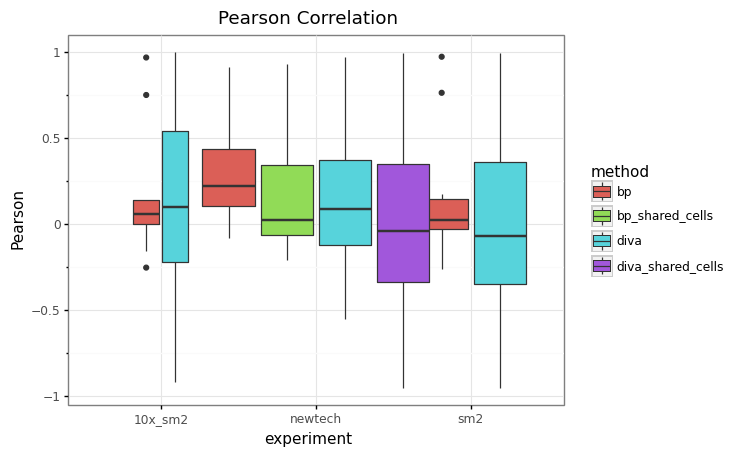

<ggplot: (8790241237757)>

In [10]:
(
    gg.ggplot(plot_df[plot_df["error_type"] == "PEAR"]) + 
    gg.aes(fill = "method", y = "error", x = "experiment") +
    gg.geom_boxplot() +
    gg.labs(title="Pearson Correlation", y="Pearson") +
    gg.theme_bw()

)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


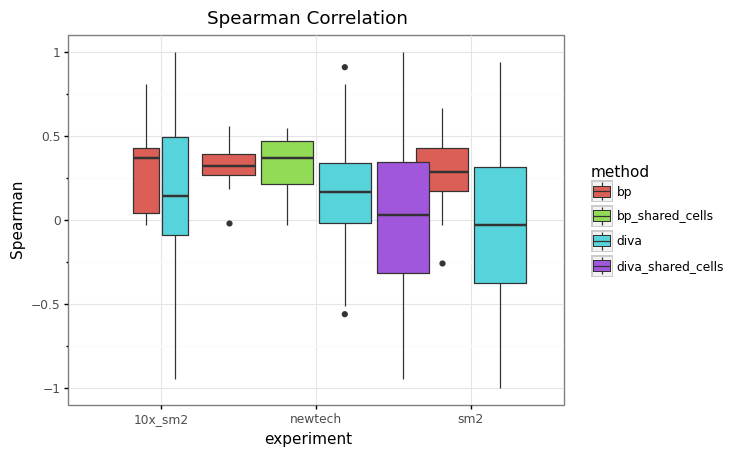

<ggplot: (8790241170413)>

In [11]:
(
    gg.ggplot(plot_df[plot_df["error_type"] == "SPR"]) + 
    gg.aes(fill = "method", y = "error", x = "experiment") +
    gg.geom_boxplot() +
    gg.labs(title="Spearman Correlation", y="Spearman") +
    gg.theme_bw()
)

# Recreation of Supp. Fig 2

[12.  5.  9. 51.  6. 17.]
[10. 11. 12. 51.  4. 12.]
[0.12483121 0.13170112 0.13743126 0.12201493 0.06190465 0.11666388
 0.32690098 0.03362237 0.00673684 0.02303051]
[0.345 0.22 0.19 0.155 0.04 0.335 0.31 0.04 0.03 0.585]
pearson: 0.21470984622151126


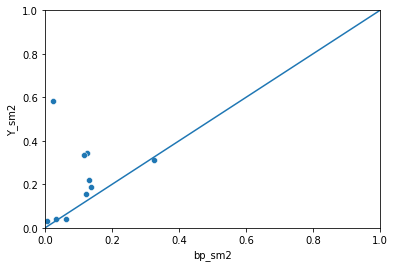

In [12]:
idx = 4
print(np.round(bp_sm2[idx,]*100))
print(np.round(Y_sm2[idx,:].astype(np.double)*100))

np.mean((bp_sm2[idx,] - Y_sm2[idx,:])**2)

print(bp_sm2[0:10,idx])
print(Y_sm2[0:10,idx])
print(f"pearson: {pearsonr(bp_sm2[0:10,idx], Y_sm2[0:10,idx])[0]}")

plot_matr = np.vstack((np.round(bp_sm2[0:10,idx],3), Y_sm2[0:10,idx]))
plot_df = pd.DataFrame(plot_matr.transpose())
plot_df.columns = ["bp_sm2", "Y_sm2"]

gg = sns.scatterplot(
    x="bp_sm2", y="Y_sm2",
    data=plot_df
)
gg.set(ylim=(0, 1))
gg.set(xlim=(0, 1))
gg.plot([0, 1], [0, 1], transform=gg.transAxes)


[ 7.  5. 10. 51. 18.  9.]
[10. 11. 12. 51.  4. 12.]
[0.22646275 0.26794666 0.20722352 0.22447623 0.17737958 0.25522393
 0.5070255  0.10182326 0.04166695 0.05238491]
[0.345 0.22 0.19 0.155 0.04 0.335 0.31 0.04 0.03 0.585]
pearson: 0.027277306201852664


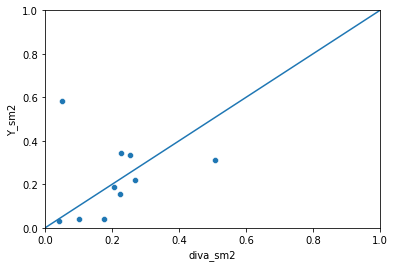

In [13]:
print(np.round(diva_sm2[idx,]*100))
print(np.round(Y_sm2[idx,:].astype(np.double)*100))


np.mean((diva_sm2[idx,] - Y_sm2[idx,:])**2)

print(diva_sm2[0:10,idx])
print(Y_sm2[0:10,idx])
print(f"pearson: {pearsonr(diva_sm2[:,idx], Y_sm2[:,idx])[0]}")

plot_matr = np.vstack((np.round(diva_sm2[0:10,idx],3), Y_sm2[0:10,idx]))
plot_df = pd.DataFrame(plot_matr.transpose())
plot_df.columns = ["diva_sm2", "Y_sm2"]

gg = sns.scatterplot(
    x="diva_sm2", y="Y_sm2",
    data=plot_df
)
gg.set(ylim=(0, 1))
gg.set(xlim=(0, 1))
gg.plot([0, 1], [0, 1], transform=gg.transAxes)
